# Kansas CAI ~~Snark~~ Review

My friend from the internet asked me to look at a list of CAI's... I can't imagine what is about to go wrong.

In [1]:
import pathlib, itables, pygris, numpy, folium, matplotlib, mapclassify
import pandas as pd
import geopandas as gpd
from pprint import pprint

itables.options.style = 'float:left;width:auto'

## Let's take a look

Time to crack open the list.

In [2]:
cai = pd.read_csv(pathlib.Path('data', 'cai.csv'))

In [3]:
itables.show(cai)

Lame! Let's just drop it in a map really quick: [here](https://felt.com/map/Kansas-CAI-Kpe4ZgiMSJm4IDOKFHlADD?loc=38.514,-98.322,7.93z&share=1) HT: Felt.com

Let's start to dig into the actual data.

In [5]:
cai = gpd.GeoDataFrame(cai, geometry=gpd.points_from_xy(cai.Longitude, cai.Latitude), crs='EPSG:4326')

<Axes: >

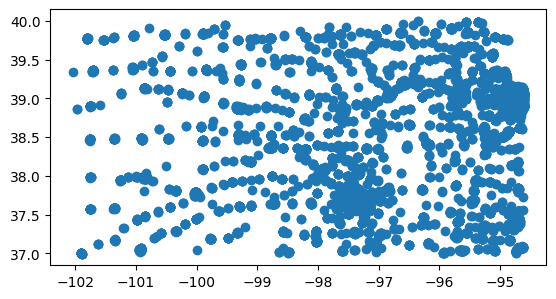

In [6]:
cai.plot()